In [1]:
!pip install tensorflow tensorflow-hub matplotlib numpy scipy

In [2]:
from platform import python_version

print(python_version())

3.8.20


In [3]:
import matplotlib.pylab as plt
import numpy as np
import scipy
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.0


In [5]:
image_shape = (224, 224)
train_dir = "C:/tmp/immersivelimit/train"
val_dir = "C:/tmp/immersivelimit/val"
test_dir = "C:/tmp/immersivelimit/test"

In [6]:
train_image_gen = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_gen.flow_from_directory(directory=train_dir, shuffle=True, target_size=image_shape)

Found 1710 images belonging to 3 classes.


In [7]:
val_image_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = val_image_gen.flow_from_directory(directory=val_dir, shuffle=True, target_size=image_shape)

Found 459 images belonging to 3 classes.


In [8]:
test_image_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_gen.flow_from_directory(directory=test_dir, shuffle=True, target_size=image_shape)

Found 141 images belonging to 3 classes.


Display samples

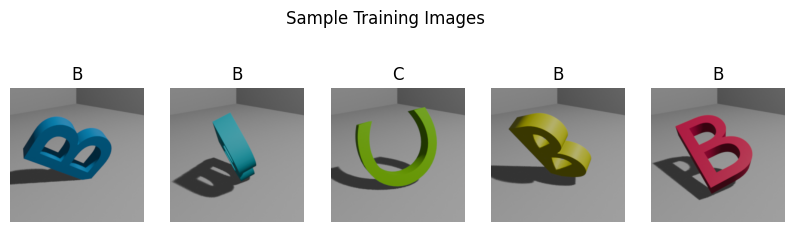

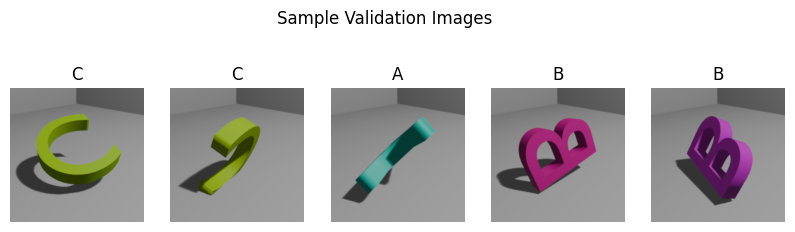

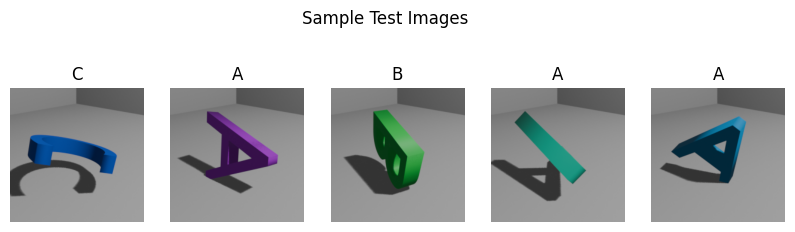

In [9]:
def display_samples(data_gen, title):
    classes = dict()
    for key, val in data_gen.class_indices.items():
        classes[val] = key
    
    sample_images, sample_labels = next(data_gen)
    
    plt.figure(figsize=(10,3))
    plt.subplots_adjust(hspace=0.5)
    for n in range(5):
        plt.subplot(1,5,n+1)
        plt.imshow(sample_images[n])
        plt.title(classes[np.argmax(sample_labels[n])])
        plt.axis('off')
    _ = plt.suptitle(title)

display_samples(train_data_gen, 'Sample Training Images')
display_samples(val_data_gen, 'Sample Validation Images')
display_samples(test_data_gen, 'Sample Test Images')

CREATE A TENSORFLOW MODEL

In [10]:
num_classes = len(train_data_gen.class_indices)
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                  trainable=False, input_shape=image_shape + (3,)), 
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc']
)

In [12]:
tSteps_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
vSteps_epoch = np.ceil(val_data_gen.samples/val_data_gen.batch_size)

epochs = 20
history = model.fit(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch = tSteps_epoch,
    validation_data = val_data_gen,
    validation_steps = vSteps_epoch,
    
)

Epoch 1/20
54/54 [==============================] - 20s 310ms/step - loss: 0.4720 - acc: 0.8181 - val_loss: 0.2240 - val_acc: 0.9390
Epoch 2/20
54/54 [==============================] - 16s 303ms/step - loss: 0.1544 - acc: 0.9608 - val_loss: 0.1633 - val_acc: 0.9499
Epoch 3/20
54/54 [==============================] - 17s 307ms/step - loss: 0.1166 - acc: 0.9632 - val_loss: 0.1418 - val_acc: 0.9455
Epoch 4/20
54/54 [==============================] - 16s 303ms/step - loss: 0.0928 - acc: 0.9737 - val_loss: 0.1450 - val_acc: 0.9412
Epoch 5/20
54/54 [==============================] - 17s 307ms/step - loss: 0.0804 - acc: 0.9760 - val_loss: 0.1215 - val_acc: 0.9521
Epoch 6/20
54/54 [==============================] - 17s 309ms/step - loss: 0.0687 - acc: 0.9801 - val_loss: 0.1145 - val_acc: 0.9542
Epoch 7/20
54/54 [==============================] - 16s 299ms/step - loss: 0.0591 - acc: 0.9860 - val_loss: 0.1004 - val_acc: 0.9673
Epoch 8/20
54/54 [==============================] - 17s 308ms/step - 

In [15]:
class_names = np.empty([len(test_data_gen.class_indices)], dtype=object, order='C')
for key, val in test_data_gen.class_indices.items():
    class_names[val] = key

test_data_gen.reset()
image_batch, label_batch = next(test_data_gen)

#prediction_probs = np.max(model.predict(image_batch), axis=1)
prediction_probs = model.predict(image_batch)
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

1/1 [==============================] - 0s 257ms/step


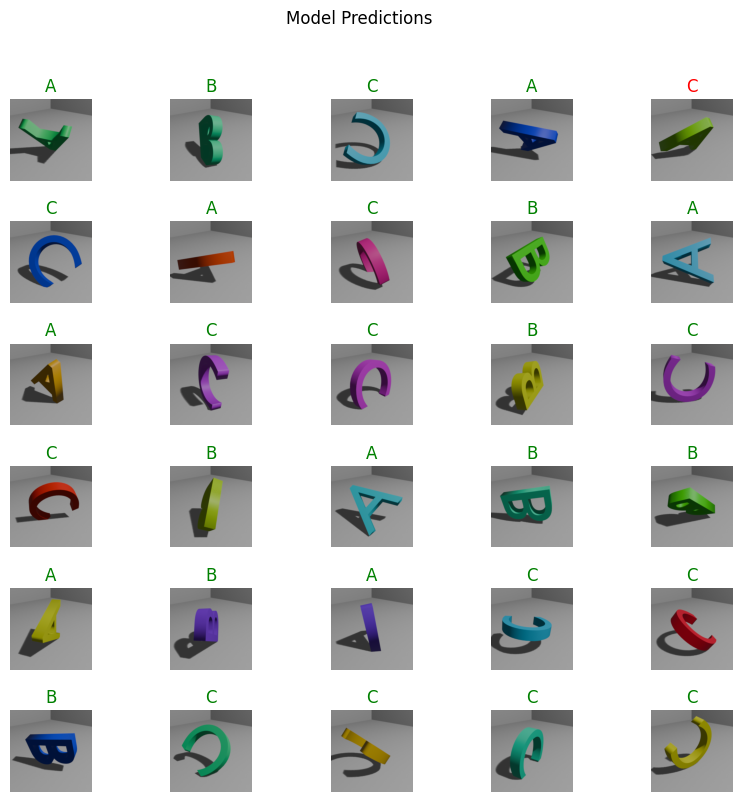

In [17]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(min(30, len(image_batch))):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
#    plt.title("Mug" if predicted_id[n] == label_id[n] else "Not Mug", color=color)
    plt.axis("off")
_ = plt.suptitle("Model Predictions")
plt.savefig("unsaif.png")